# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import copy
import pickle

import edge2vec.transition3 as transitions
import edge2vec.edge2vec3 as edge2vec

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv

from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.graph import Graph

from ray import tune
from ray.tune.schedulers import ASHAScheduler

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch_device)

Using device: cpu


# Load Data

Load all edges of the knowledge graph.

Adapted by Rosa Zwart from Jupyter Notebooks found at https://github.com/PPerdomoQ/rare-disease-explainer

In [3]:
edges = pd.read_csv('output/new_kg_edges.csv', header=0)
edges.head(10)

,id,subject,object,relation_id,relation_label,relation_iri
0,3d6516a6-a46a-4a31-b3a3-26b99382fbaf,FlyBase:FBgn0011676,ENSEMBL:ENSCAFG00000009820,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
1,5b3867c6-befd-4bad-b61c-97de75ae22c6,HGNC:12012,HGNC:11946,RO:0002434,interacts with,http://purl.obolibrary.org/obo/RO_0002434
2,a276b95d-2137-49a2-84fd-585298f81a1f,HGNC:15516,HP:0002650,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
3,ff4c3b46-0c34-4e73-9754-5351221f4b40,WormBase:WBGene00000065,ENSEMBL:ENSOANG00000007850,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
4,4f82bdff-cbcb-45b2-95d7-086b142257c9,HGNC:6485,HGNC:329,RO:0002434,interacts with,http://purl.obolibrary.org/obo/RO_0002434
5,48dee90f-a334-459b-8cbc-999bc745c49f,ENSEMBL:ENSECAG00000023844,ENSEMBL:ENSGALG00000042388,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
6,657f2866-d1a5-405b-bd02-dec3964150d5,MGI:3621491,MP:0011966,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
7,25a138d1-4498-4864-96c0-12c1f91ae493,MGI:1859649,ENSEMBL:ENSACAG00000001940,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
8,439999a4-578f-4641-b022-90d2ea670eed,ClinVarVariant:803793,MONDO:0010679,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
9,8b79b610-3a7b-4f87-af8c-47010bc60e69,PomBase:SPAC27F1.02c,RGD:1559479,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017


Extract the relevant columns and rename these columns.

In [4]:
edges = edges[['subject', 'relation_label', 'object']]
edges.rename(columns={'subject': 'head', 'relation_label': 'relation', 'object': 'tail'}, inplace=True)
edges.head(10)

,head,relation,tail
0,FlyBase:FBgn0011676,in orthology relationship with,ENSEMBL:ENSCAFG00000009820
1,HGNC:12012,interacts with,HGNC:11946
2,HGNC:15516,causes condition,HP:0002650
3,WormBase:WBGene00000065,in orthology relationship with,ENSEMBL:ENSOANG00000007850
4,HGNC:6485,interacts with,HGNC:329
5,ENSEMBL:ENSECAG00000023844,in orthology relationship with,ENSEMBL:ENSGALG00000042388
6,MGI:3621491,causes condition,MP:0011966
7,MGI:1859649,in orthology relationship with,ENSEMBL:ENSACAG00000001940
8,ClinVarVariant:803793,causes condition,MONDO:0010679
9,PomBase:SPAC27F1.02c,in orthology relationship with,RGD:1559479


In [5]:
print(f'There are {edges.shape[0]} edges')

There are 85954 edges


Load all nodes of the knowledge graph.

In [6]:
nodes = pd.read_csv('output/new_kg_nodes.csv', header=0)
nodes['index_id'] = nodes.index
nodes.head(10)

,id,label,iri,semantic,index_id
0,MP:0020358,abnormal inhibitory synapse morphology,http://purl.obolibrary.org/obo/MP_0020358,phenotype,0
1,HP:0000670,Carious teeth,http://purl.obolibrary.org/obo/HP_0000670,phenotype,1
2,ENSEMBL:ENSCAFG00000017522,ENSEMBL:ENSCAFG00000017522,http://ensembl.org/id/ENSCAFG00000017522,gene,2
3,ZFIN:ZDB-GENE-070705-188,chrm1b,http://zfin.org/ZDB-GENE-070705-188,gene,3
4,HP:0000544,External ophthalmoplegia,http://purl.obolibrary.org/obo/HP_0000544,phenotype,4
5,ZFIN:ZDB-GENE-040426-1146,traf3ip1,http://zfin.org/ZDB-GENE-040426-1146,gene,5
6,MP:0001900,impaired synaptic plasticity,http://purl.obolibrary.org/obo/MP_0001900,phenotype,6
7,ClinVarVariant:650539,NM_004006.2(DMD):c.6439-10_8217+32103dup,http://www.ncbi.nlm.nih.gov/clinvar/variation/...,variant,7
8,ZFIN:ZDB-GENE-070228-4,drp2,http://zfin.org/ZDB-GENE-070228-4,gene,8
9,HGNC:7611,MYOD1,https://www.genenames.org/data/gene-symbol-rep...,gene,9


In [7]:
print(f'There are {nodes.shape[0]} nodes')

There are 10237 nodes


Extract the relevant columns.

In [8]:
nodes = nodes[['index_id', 'id', 'semantic', 'label']]
nodes.head(10)

,index_id,id,semantic,label
0,0,MP:0020358,phenotype,abnormal inhibitory synapse morphology
1,1,HP:0000670,phenotype,Carious teeth
2,2,ENSEMBL:ENSCAFG00000017522,gene,ENSEMBL:ENSCAFG00000017522
3,3,ZFIN:ZDB-GENE-070705-188,gene,chrm1b
4,4,HP:0000544,phenotype,External ophthalmoplegia
5,5,ZFIN:ZDB-GENE-040426-1146,gene,traf3ip1
6,6,MP:0001900,phenotype,impaired synaptic plasticity
7,7,ClinVarVariant:650539,variant,NM_004006.2(DMD):c.6439-10_8217+32103dup
8,8,ZFIN:ZDB-GENE-070228-4,gene,drp2
9,9,HGNC:7611,gene,MYOD1


Convert categorical to numerical values for the semantic groups.

In [9]:
nodes['semantic'] = nodes['semantic'].astype('category')
nodes['semantic_id'] = nodes['semantic'].cat.codes
nodes.head(10)

,index_id,id,semantic,label,semantic_id
0,0,MP:0020358,phenotype,abnormal inhibitory synapse morphology,8
1,1,HP:0000670,phenotype,Carious teeth,8
2,2,ENSEMBL:ENSCAFG00000017522,gene,ENSEMBL:ENSCAFG00000017522,5
3,3,ZFIN:ZDB-GENE-070705-188,gene,chrm1b,5
4,4,HP:0000544,phenotype,External ophthalmoplegia,8
5,5,ZFIN:ZDB-GENE-040426-1146,gene,traf3ip1,5
6,6,MP:0001900,phenotype,impaired synaptic plasticity,8
7,7,ClinVarVariant:650539,variant,NM_004006.2(DMD):c.6439-10_8217+32103dup,10
8,8,ZFIN:ZDB-GENE-070228-4,gene,drp2,5
9,9,HGNC:7611,gene,MYOD1,5


In [ ]:
nodes.to_csv('output/indexed_nodes.csv', index=False)

The dictionary below can be used as mapping between generated semantic ID and semantic group label.

In [10]:
node_semantic_dict = dict(enumerate(nodes['semantic'].cat.categories))
node_semantic_dict

{0: 'biological artifact',
 1: 'biological process',
 2: 'cellular component',
 3: 'disease',
 4: 'drug',
 5: 'gene',
 6: 'genotype',
 7: 'molecular function',
 8: 'phenotype',
 9: 'taxon',
 10: 'variant'}

Merge nodes and edges in order to join semantic classes of nodes with heads and tails of the edges.

In [11]:
kg_df = pd.merge(edges, nodes,
                 left_on='head', right_on='id',
                 how='left')
kg_df = kg_df[['head', 'label', 'semantic_id', 'index_id', 'relation', 'tail']]
kg_df.rename(columns={'label': 'label_head', 'semantic_id': 'class_head', 'index_id': 'index_head'}, inplace=True)
kg_df.head(10)

,head,label_head,class_head,index_head,relation,tail
0,FlyBase:FBgn0011676,Nos,5,9594,in orthology relationship with,ENSEMBL:ENSCAFG00000009820
1,HGNC:12012,TPM3,5,1813,interacts with,HGNC:11946
2,HGNC:15516,XYLT1,5,3228,causes condition,HP:0002650
3,WormBase:WBGene00000065,act-3,5,3272,in orthology relationship with,ENSEMBL:ENSOANG00000007850
4,HGNC:6485,LAMA5,5,4641,interacts with,HGNC:329
5,ENSEMBL:ENSECAG00000023844,ENSEMBL:ENSECAG00000023844,5,9822,in orthology relationship with,ENSEMBL:ENSGALG00000042388
6,MGI:3621491,Dmd<mdx>/Dmd<mdx> [C57BL/10ScSn-Dmd<mdx>/J],6,4598,causes condition,MP:0011966
7,MGI:1859649,Ctnnal1,5,5773,in orthology relationship with,ENSEMBL:ENSACAG00000001940
8,ClinVarVariant:803793,NM_004006.3(DMD):c.9950_9951del (p.Lys3317fs),10,1815,causes condition,MONDO:0010679
9,PomBase:SPAC27F1.02c,cdc8,5,3477,in orthology relationship with,RGD:1559479


In [12]:
kg_df = pd.merge(kg_df, nodes,
                 left_on='tail', right_on='id',
                 how='left')
kg_df = kg_df[['head', 'label_head', 'class_head', 'index_head', 'relation', 'tail', 'label', 'semantic_id', 'index_id']]
kg_df.rename(columns={'label': 'label_tail', 'semantic_id': 'class_tail', 'index_id': 'index_tail'}, inplace=True)
kg_df.head(10)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail
0,FlyBase:FBgn0011676,Nos,5,9594,in orthology relationship with,ENSEMBL:ENSCAFG00000009820,ENSEMBL:ENSCAFG00000009820,5,7362
1,HGNC:12012,TPM3,5,1813,interacts with,HGNC:11946,TNNI2,5,7360
2,HGNC:15516,XYLT1,5,3228,causes condition,HP:0002650,Scoliosis,8,2102
3,WormBase:WBGene00000065,act-3,5,3272,in orthology relationship with,ENSEMBL:ENSOANG00000007850,ENSEMBL:ENSOANG00000007850,5,2284
4,HGNC:6485,LAMA5,5,4641,interacts with,HGNC:329,AGRN,5,2205
5,ENSEMBL:ENSECAG00000023844,ENSEMBL:ENSECAG00000023844,5,9822,in orthology relationship with,ENSEMBL:ENSGALG00000042388,A0A3Q2TS00,5,9573
6,MGI:3621491,Dmd<mdx>/Dmd<mdx> [C57BL/10ScSn-Dmd<mdx>/J],6,4598,causes condition,MP:0011966,abnormal auditory brainstem response waveform ...,8,839
7,MGI:1859649,Ctnnal1,5,5773,in orthology relationship with,ENSEMBL:ENSACAG00000001940,ENSEMBL:ENSACAG00000001940,5,2803
8,ClinVarVariant:803793,NM_004006.3(DMD):c.9950_9951del (p.Lys3317fs),10,1815,causes condition,MONDO:0010679,Duchenne muscular dystrophy,3,4672
9,PomBase:SPAC27F1.02c,cdc8,5,3477,in orthology relationship with,RGD:1559479,Tpm2,5,6456


The indices in the `index_id` column can be found as the actual indices of the row. So, this column can be removed as it was only needed for merging purposes.

In [13]:
nodes.drop('index_id', axis=1, inplace=True)
nodes.head(10)

,id,semantic,label,semantic_id
0,MP:0020358,phenotype,abnormal inhibitory synapse morphology,8
1,HP:0000670,phenotype,Carious teeth,8
2,ENSEMBL:ENSCAFG00000017522,gene,ENSEMBL:ENSCAFG00000017522,5
3,ZFIN:ZDB-GENE-070705-188,gene,chrm1b,5
4,HP:0000544,phenotype,External ophthalmoplegia,8
5,ZFIN:ZDB-GENE-040426-1146,gene,traf3ip1,5
6,MP:0001900,phenotype,impaired synaptic plasticity,8
7,ClinVarVariant:650539,variant,NM_004006.2(DMD):c.6439-10_8217+32103dup,10
8,ZFIN:ZDB-GENE-070228-4,gene,drp2,5
9,HGNC:7611,gene,MYOD1,5


In [14]:
kg_df.head(15)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail
0,FlyBase:FBgn0011676,Nos,5,9594,in orthology relationship with,ENSEMBL:ENSCAFG00000009820,ENSEMBL:ENSCAFG00000009820,5,7362
1,HGNC:12012,TPM3,5,1813,interacts with,HGNC:11946,TNNI2,5,7360
2,HGNC:15516,XYLT1,5,3228,causes condition,HP:0002650,Scoliosis,8,2102
3,WormBase:WBGene00000065,act-3,5,3272,in orthology relationship with,ENSEMBL:ENSOANG00000007850,ENSEMBL:ENSOANG00000007850,5,2284
4,HGNC:6485,LAMA5,5,4641,interacts with,HGNC:329,AGRN,5,2205
5,ENSEMBL:ENSECAG00000023844,ENSEMBL:ENSECAG00000023844,5,9822,in orthology relationship with,ENSEMBL:ENSGALG00000042388,A0A3Q2TS00,5,9573
6,MGI:3621491,Dmd<mdx>/Dmd<mdx> [C57BL/10ScSn-Dmd<mdx>/J],6,4598,causes condition,MP:0011966,abnormal auditory brainstem response waveform ...,8,839
7,MGI:1859649,Ctnnal1,5,5773,in orthology relationship with,ENSEMBL:ENSACAG00000001940,ENSEMBL:ENSACAG00000001940,5,2803
8,ClinVarVariant:803793,NM_004006.3(DMD):c.9950_9951del (p.Lys3317fs),10,1815,causes condition,MONDO:0010679,Duchenne muscular dystrophy,3,4672
9,PomBase:SPAC27F1.02c,cdc8,5,3477,in orthology relationship with,RGD:1559479,Tpm2,5,6456


# Preparation E2V Data

Encode string values of relation labels as numeric values.

In [15]:
kg_df['type'], relation_labels = pd.factorize(kg_df['relation'])
kg_df.head(10)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,FlyBase:FBgn0011676,Nos,5,9594,in orthology relationship with,ENSEMBL:ENSCAFG00000009820,ENSEMBL:ENSCAFG00000009820,5,7362,0
1,HGNC:12012,TPM3,5,1813,interacts with,HGNC:11946,TNNI2,5,7360,1
2,HGNC:15516,XYLT1,5,3228,causes condition,HP:0002650,Scoliosis,8,2102,2
3,WormBase:WBGene00000065,act-3,5,3272,in orthology relationship with,ENSEMBL:ENSOANG00000007850,ENSEMBL:ENSOANG00000007850,5,2284,0
4,HGNC:6485,LAMA5,5,4641,interacts with,HGNC:329,AGRN,5,2205,1
5,ENSEMBL:ENSECAG00000023844,ENSEMBL:ENSECAG00000023844,5,9822,in orthology relationship with,ENSEMBL:ENSGALG00000042388,A0A3Q2TS00,5,9573,0
6,MGI:3621491,Dmd<mdx>/Dmd<mdx> [C57BL/10ScSn-Dmd<mdx>/J],6,4598,causes condition,MP:0011966,abnormal auditory brainstem response waveform ...,8,839,2
7,MGI:1859649,Ctnnal1,5,5773,in orthology relationship with,ENSEMBL:ENSACAG00000001940,ENSEMBL:ENSACAG00000001940,5,2803,0
8,ClinVarVariant:803793,NM_004006.3(DMD):c.9950_9951del (p.Lys3317fs),10,1815,causes condition,MONDO:0010679,Duchenne muscular dystrophy,3,4672,2
9,PomBase:SPAC27F1.02c,cdc8,5,3477,in orthology relationship with,RGD:1559479,Tpm2,5,6456,0


Index list can be used later for converting back to the label of the relation.

In [16]:
relation_labels

Index(['in orthology relationship with', 'interacts with', 'causes condition',
       'targets', 'is part of', 'found in', 'has role in modeling', 'is of',
       'associated with phenotype', 'contributes to condition',
       'likely causes condition', 'has affected feature', 'expresses gene',
       'enables', 'is substance that treats', 'involved in',
       'colocalizes with', 'is allele of', 'is variant in', 'has genotype'],
      dtype='object')

Extract the relevant columns for applying the Edge2Vec method.

In [17]:
edge2vec_df = kg_df.copy()
#edge2vec_df = kg_df.drop(['head', 'relation', 'tail'], axis=1)
edge2vec_df['index_head'] = edge2vec_df['index_head'].apply(str)
edge2vec_df['index_tail'] = edge2vec_df['index_tail'].apply(str)
edge2vec_df.head(10)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,FlyBase:FBgn0011676,Nos,5,9594,in orthology relationship with,ENSEMBL:ENSCAFG00000009820,ENSEMBL:ENSCAFG00000009820,5,7362,0
1,HGNC:12012,TPM3,5,1813,interacts with,HGNC:11946,TNNI2,5,7360,1
2,HGNC:15516,XYLT1,5,3228,causes condition,HP:0002650,Scoliosis,8,2102,2
3,WormBase:WBGene00000065,act-3,5,3272,in orthology relationship with,ENSEMBL:ENSOANG00000007850,ENSEMBL:ENSOANG00000007850,5,2284,0
4,HGNC:6485,LAMA5,5,4641,interacts with,HGNC:329,AGRN,5,2205,1
5,ENSEMBL:ENSECAG00000023844,ENSEMBL:ENSECAG00000023844,5,9822,in orthology relationship with,ENSEMBL:ENSGALG00000042388,A0A3Q2TS00,5,9573,0
6,MGI:3621491,Dmd<mdx>/Dmd<mdx> [C57BL/10ScSn-Dmd<mdx>/J],6,4598,causes condition,MP:0011966,abnormal auditory brainstem response waveform ...,8,839,2
7,MGI:1859649,Ctnnal1,5,5773,in orthology relationship with,ENSEMBL:ENSACAG00000001940,ENSEMBL:ENSACAG00000001940,5,2803,0
8,ClinVarVariant:803793,NM_004006.3(DMD):c.9950_9951del (p.Lys3317fs),10,1815,causes condition,MONDO:0010679,Duchenne muscular dystrophy,3,4672,2
9,PomBase:SPAC27F1.02c,cdc8,5,3477,in orthology relationship with,RGD:1559479,Tpm2,5,6456,0


In [18]:
print(f'There are {edge2vec_df.shape[0]} edges')

There are 85954 edges


In [107]:
edge2vec_df.to_csv('output/indexed_edges.csv', index=False)

Initialize edge list with keys 'type' and 'weight'. The 'weight' of each edge is initialized to 1.0. 

In [19]:
G = nx.from_pandas_edgelist(edge2vec_df, 'index_head', 'index_tail', 'type', create_using=nx.DiGraph(), edge_key= (('type', int),('id',int)))
G = G.to_undirected()
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1.0

In [20]:
for node in G.nodes(data=True):
    print('First node in graph:', node)
    break

for edge in G.edges(data=True):
    print('First edge in graph:', edge)
    break

print('Total number of edges is {}'.format(G.number_of_edges()))
print('Total number of nodes is {}'.format(G.number_of_nodes()))

First node in graph: ('9594', {})
First edge in graph: ('9594', '7362', {'type': 0, 'weight': 1.0})
Total number of edges is 54994
Total number of nodes is 10237


# Obtain Node Embeddings with E2V

In [21]:
type_size = len(set(edge2vec_df['type']))
print(f'There are {type_size} edge types')

There are 20 edge types


Define parameters and generate edge type transition matrix using Edge2Vec EM approach

In [22]:
epoch = 10  # number of epochs
num_walks = 2   # number of walks per node
walk_length = 7 # length of each walk
directed = True
p = 0.7
q = 1
e_step = 3

print('Initializing transition matrix...')
M = transitions.initialize_edge_type_matrix(type_size)

print('Updating transition matrix...')
for i in range(epoch):
    walks = transitions.simulate_walks_1(G, num_walks, walk_length, M, directed, p, q) # M step
    print(f'{i}th iteration of updating matrix')
    M = transitions.update_trans_matrix(walks, type_size, e_step) # E step

print("Finished generating values for transition matrix!")

Initializing transition matrix...
Updating transition matrix...
Walk iteration:
1 / 2
2 / 2
0th iteration of updating matrix


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Walk iteration:
1 / 2
2 / 2
1th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
2th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
3th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
4th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
5th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
6th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
7th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
8th iteration of updating matrix
Walk iteration:
1 / 2
2 / 2
9th iteration of updating matrix
Finished generating values for transition matrix!


In [23]:
print('Overview of resulting edge type transition matrix (float values have been truncated to fit the view!):')
print('\n'.join(['\t'.join([str(cell)[:5] for cell in row]) for row in M]))

Overview of resulting edge type transition matrix (float values have been truncated to fit the view!):
0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	0.5	0.5
1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.999	0.5
1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.999	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1

Generate walks constrained by final edge type transition matrix

In [24]:
print('Generate walks constrained by edge type transition matrix...')
walks = edge2vec.simulate_walks_2(G, num_walks, walk_length, M, p, q)

Generate walks constrained by edge type transition matrix...
Walk iteration:
1 / 2
2 / 2


Generate node embeddings using Word2Vec (skip-gram model) with as input the generated walks

In [25]:
dim = 64    # desired dimension of the node embedding
window_size = walk_length - 1   # maximum distance between predicted and context node
workers = 8 # threads used
epochs = 10

w2v_model = edge2vec.Word2Vec(walks, vector_size=dim, window=window_size, min_count=0, sg=1, workers=workers, epochs=epochs)

Save the node embeddings

In [26]:
word_vectors = w2v_model.wv
word_vectors.save('output/w2v.dvectors')

In [27]:
e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(w2v_model.wv.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(w2v_model.wv[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')

The embeddings of each node in the graph

In [28]:
e2v_embedding

,Node,Embedding
0,0,"[0.13517001, -0.25358334, 0.07978077, 0.045121..."
1,1,"[0.16805942, -0.8350107, 0.19610697, 0.1981789..."
2,2,"[0.2186089, 0.50546986, 0.6193271, 0.0123952, ..."
3,3,"[0.29987955, -0.30054563, 0.15258668, 0.367052..."
4,4,"[0.1618276, -0.36085665, 0.295463, 0.17283706,..."
...,...,...
10232,10232,"[0.3500288, -1.1846579, 0.15232153, 0.05306821..."
10233,10233,"[0.17927206, -0.17169905, -0.12125319, 0.18529..."
10234,10234,"[0.24352823, -0.24893956, 0.22431412, 0.153569..."
10235,10235,"[0.3218023, -0.7156479, 0.30151767, -0.3144425..."


# Link Prediction

Creating a graph including the node embeddings as features of each node.

In [29]:
embedded_node_G = nx.Graph()

for ind, node in e2v_embedding.iterrows(): 
  embedded_node_G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edge2vec_df.iterrows(): 
  embedded_node_G.add_edge(int(edge['index_head']), int(edge['index_tail']))
    
for node in embedded_node_G.nodes(data=True):
    print(node)
    break
for edge in embedded_node_G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(embedded_node_G.number_of_edges()))
print("Number of nodes is {}".format(embedded_node_G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.1352, -0.2536,  0.0798,  0.0451,  0.0747, -0.2546, -0.0705, -0.0646,
        -0.2445, -0.0202,  0.0493, -0.1636, -0.0623, -0.0508,  0.0288,  0.2002,
        -0.1173, -0.0943, -0.0744,  0.1843,  0.2936,  0.1871,  0.0121, -0.1656,
        -0.0181,  0.1075, -0.2460, -0.0466,  0.0871,  0.0957,  0.0087,  0.0946,
         0.0594, -0.0770, -0.0258,  0.0603, -0.0336, -0.0642,  0.0645,  0.0790,
        -0.0484, -0.0365, -0.0421,  0.0775,  0.1667, -0.0309,  0.0096, -0.1305,
        -0.0259,  0.1215,  0.0949,  0.0348,  0.1015,  0.1412,  0.0737,  0.0777,
         0.0288, -0.0531, -0.1087,  0.0693, -0.1133, -0.0443, -0.0622, -0.0670])})
(0, 5535, {})
Number of edges is 54994
Number of nodes is 10237


## Generate graph datasets for training, validation and testing

Transductive link prediction split (https://zqfang.github.io/2021-08-12-graph-linkpredict/):
- Train/validation/test sets are on the same graph
- The dataset consists of one graph
- The entire graph can be observed in all dataset splits
- The labels of the edges are split

In [30]:
dataset = GraphDataset(
    embedded_node_G,
    task='link_pred',
    edge_train_mode='all'
)

datasets = {}
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1]
)

input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

print(f'Input dimension (embedding dimension): {input_dim} \n Number of edge classes (link or no link): {num_classes}')   

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Input dimension (embedding dimension): 64 
 Number of edge classes (link or no link): 2


Dataloaders allow to feed data into the model by batch.

In [31]:
dataloaders = {split: DataLoader(ds, collate_fn=Batch.collate([]), batch_size=1, shuffle=(split=='train')) for split, ds in datasets.items()}

In [73]:
print('--- training set ---')

for i, batch in enumerate(dataloaders['train']):
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    
    print('feat', feat.detach().numpy().shape, 'contains all features per node')
    print('edge_index', edge_index.detach().numpy().shape, 'contains existing edges with [0] for head nodes and [1] for tail nodes (all edges * 2 * 0.8)')
    print(edge_label_index.detach().numpy())
    print('edge_label_index', edge_label_index.detach().numpy().shape, 'contains edges and no edges with [0] for head nodes and [1] for tail nodes, 50/50 ratio')
    print('edge label', batch.edge_label.detach().numpy().shape)
    
    first_nodes_indices = edge_label_index[0,:]
    print(first_nodes_indices.shape)
    print(torch.max(first_nodes_indices))
    
    nodes_first = torch.index_select(feat, 0, edge_label_index[0,:])
    print('nodes_first', nodes_first.detach().numpy().shape, 'contains all head nodes of an existing or non-existing edge')
    nodes_second = torch.index_select(feat, 0, edge_label_index[1,:])
    print('nodes_second', nodes_second.detach().numpy().shape, 'contains all tail nodes of an existing or non-existing edge')
    
    pred = torch.sum(nodes_first * nodes_second, dim=-1)
    print('pred', pred.detach().numpy(), 'with shape', pred.detach().numpy().shape, 'contains prediction of whether or not an edge exists between the node pairs')
    
    print('edge_label', batch.edge_label.type(pred.dtype), 'with shape', batch.edge_label.type(pred.dtype).shape, 'contains the true labels of an edge existing or not')
    
print('--- validation set ---')
    
for i, batch in enumerate(dataloaders['val']):
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    
    print('feat', feat.detach().numpy().shape)
    print('edge_index', edge_index.detach().numpy().shape)
    print('edge_label_index', edge_label_index.detach().numpy().shape)
    print('edge label', batch.edge_label.detach().numpy().shape)
    
print('--- test set ---')
    
for i, batch in enumerate(dataloaders['test']):
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    
    print('feat', feat.detach().numpy().shape)
    print('edge_index', edge_index.detach().numpy().shape)
    print('edge_label_index', edge_label_index.detach().numpy().shape)
    print('edge label', batch.edge_label.detach().numpy().shape)

--- training set ---
feat (10237, 64) contains all features per node
edge_index (2, 87990) contains existing edges with [0] for head nodes and [1] for tail nodes (all edges * 2 * 0.8)
[[ 2714  4936  2173 ...  1378  3513  5727]
 [ 2851  9866 10020 ...  2618  5009   957]]
edge_label_index (2, 175980) contains edges and no edges with [0] for head nodes and [1] for tail nodes, 50/50 ratio
edge label (175980,)
torch.Size([175980])
tensor(10236)
nodes_first (175980, 64) contains all head nodes of an existing or non-existing edge
nodes_second (175980, 64) contains all tail nodes of an existing or non-existing edge
pred [12.252176  11.689496   8.385357  ...  2.020379   4.269898   1.8066634] with shape (175980,) contains prediction of whether or not an edge exists between the node pairs
edge_label tensor([1., 1., 1.,  ..., 0., 0., 0.]) with shape torch.Size([175980]) contains the true labels of an edge existing or not
--- validation set ---
feat (10237, 64)
edge_index (2, 87990)
edge_label_inde

## Train GNN

In [33]:
class LinkPredModel(torch.nn.Module):
    """
        Architecture contains Batch Normalization layers (https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) 
        between the SAGEConvolutional layers.
    """
    def __init__(self, input_size, hidden_size, out_size, num_layers, aggr, dropout, device):
        super(LinkPredModel, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        
        self.convs.append(SAGEConv(input_size, hidden_size, normalize=True, aggr=aggr)) # input node embedding features, output is size of hidden layers
        self.bns.append(nn.BatchNorm1d(hidden_size))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_size, hidden_size, normalize=True, aggr=aggr))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.convs.append(SAGEConv(hidden_size, out_size, normalize=True, aggr=aggr))
        self.bns.append(nn.BatchNorm1d(out_size))

        self.dropout = dropout
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        self.device = device


    def forward(self, x, edge_index, edge_label_index, training = True):
        x = x.to(self.device)
        edge_index = edge_index.to(self.device)
        edge_label_index = edge_label_index.to(self.device)

        for i in range(len(self.convs) - 1):
          x = self.convs[i](x, edge_index)
          x = self.bns[i](x)
          x = F.leaky_relu(x)
          x = F.dropout(x, p=self.dropout, training=training)
        
        x = self.convs[-1](x, edge_index)  
        x = self.bns[-1](x)
        

        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())
        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())
        pred = torch.sum(nodes_first * nodes_second, dim=-1)
        
        return pred, x
    
    def loss(self, pred, label):
        return self.loss_fn(pred, label)

def train(model, dataloaders, optimizer, args, ho = False):
    val_max = 0
    best_model = model
    best_x = None
    train_per = []
    val_per = []
    test_per = []
    loss_per = []
    
    print('Start Train Function')
    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
            batch.to(args["device"])
            model.train()
            optimizer.zero_grad()
            pred, x = model(feat, edge_index, edge_label_index)
            loss = model.loss(pred, batch.edge_label.type(pred.dtype))

            loss.backward()
            optimizer.step()

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
                best_x = x
            if ho: 
                tune.report(val_auc=score_val, train_auc = score_train, test_auc = score_test )
            
            loss_per.append(loss.detach().cpu().numpy())
            train_per.append(score_train)
            val_per.append(score_val)
            test_per.append(score_test)
            
            
    return best_model, best_x, [loss_per, train_per, val_per, test_per]

def test(model, dataloader, args):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred)
        score += roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return score

### Predefined Arguments

Train GNN with predefined arguments

In [34]:
args = {
    "device" : torch_device,   # insert torch_device, or 'cpu' 
    "hidden_dim" : 264,
    'output_dim':64,
    "epochs" : 150, 
    'lr': 0.07, 
    'aggr': 'mean', 
    'layers': 2, 
    'dropout': 0.2
}

model = LinkPredModel(input_dim, args["hidden_dim"], args['output_dim'], args['layers'], args['aggr'], args['dropout'], args["device"]).to(args["device"])
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)

In [35]:
best_model, best_x, performance = train(model, dataloaders, optimizer, args)

best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)

print('Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(best_train_roc, best_val_roc, best_test_roc))

Start Train Function
Epoch: 001, Train: 0.9524, Val: 0.9324, Test: 0.9363, Loss: 2.43454


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 002, Train: 0.9505, Val: 0.9303, Test: 0.9349, Loss: 2.27322


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 003, Train: 0.9301, Val: 0.9153, Test: 0.9160, Loss: 2.05979


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 004, Train: 0.9541, Val: 0.9288, Test: 0.9334, Loss: 2.05142


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 005, Train: 0.9615, Val: 0.9338, Test: 0.9377, Loss: 1.87227


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 006, Train: 0.9640, Val: 0.9389, Test: 0.9406, Loss: 1.79530


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 007, Train: 0.9654, Val: 0.9434, Test: 0.9442, Loss: 1.61475


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 008, Train: 0.9671, Val: 0.9484, Test: 0.9500, Loss: 1.46951


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 009, Train: 0.9664, Val: 0.9485, Test: 0.9511, Loss: 1.36276


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 010, Train: 0.9631, Val: 0.9463, Test: 0.9491, Loss: 1.28310


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 011, Train: 0.9635, Val: 0.9468, Test: 0.9494, Loss: 1.19724


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 012, Train: 0.9667, Val: 0.9486, Test: 0.9513, Loss: 1.12312


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 013, Train: 0.9683, Val: 0.9503, Test: 0.9531, Loss: 1.04294


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 014, Train: 0.9702, Val: 0.9519, Test: 0.9546, Loss: 0.98321


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 015, Train: 0.9710, Val: 0.9532, Test: 0.9557, Loss: 0.90939


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 016, Train: 0.9714, Val: 0.9546, Test: 0.9568, Loss: 0.86142


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 017, Train: 0.9710, Val: 0.9555, Test: 0.9575, Loss: 0.80892


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 018, Train: 0.9711, Val: 0.9564, Test: 0.9582, Loss: 0.76383


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 019, Train: 0.9708, Val: 0.9572, Test: 0.9590, Loss: 0.72207


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 020, Train: 0.9714, Val: 0.9581, Test: 0.9597, Loss: 0.67983


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 021, Train: 0.9714, Val: 0.9588, Test: 0.9604, Loss: 0.64743


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 022, Train: 0.9723, Val: 0.9597, Test: 0.9613, Loss: 0.62318


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 023, Train: 0.9726, Val: 0.9606, Test: 0.9622, Loss: 0.59380


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 024, Train: 0.9731, Val: 0.9616, Test: 0.9631, Loss: 0.56653


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 025, Train: 0.9738, Val: 0.9627, Test: 0.9642, Loss: 0.54283


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 026, Train: 0.9747, Val: 0.9640, Test: 0.9654, Loss: 0.52810


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 027, Train: 0.9764, Val: 0.9653, Test: 0.9667, Loss: 0.51501


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 028, Train: 0.9772, Val: 0.9667, Test: 0.9681, Loss: 0.50278


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 029, Train: 0.9783, Val: 0.9681, Test: 0.9694, Loss: 0.49104


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 030, Train: 0.9794, Val: 0.9694, Test: 0.9707, Loss: 0.48682


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 031, Train: 0.9801, Val: 0.9706, Test: 0.9719, Loss: 0.47650


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 032, Train: 0.9810, Val: 0.9717, Test: 0.9730, Loss: 0.47082


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 033, Train: 0.9819, Val: 0.9726, Test: 0.9740, Loss: 0.46667


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 034, Train: 0.9824, Val: 0.9734, Test: 0.9750, Loss: 0.45875


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 035, Train: 0.9830, Val: 0.9740, Test: 0.9758, Loss: 0.45592


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 036, Train: 0.9835, Val: 0.9746, Test: 0.9765, Loss: 0.45067


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 037, Train: 0.9835, Val: 0.9749, Test: 0.9770, Loss: 0.44659


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 038, Train: 0.9838, Val: 0.9752, Test: 0.9773, Loss: 0.44376


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 039, Train: 0.9840, Val: 0.9754, Test: 0.9776, Loss: 0.44105


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 040, Train: 0.9842, Val: 0.9756, Test: 0.9778, Loss: 0.44208


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 041, Train: 0.9843, Val: 0.9758, Test: 0.9780, Loss: 0.43740


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 042, Train: 0.9841, Val: 0.9759, Test: 0.9781, Loss: 0.43383


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 043, Train: 0.9851, Val: 0.9761, Test: 0.9782, Loss: 0.43490


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 044, Train: 0.9850, Val: 0.9762, Test: 0.9782, Loss: 0.43343


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 045, Train: 0.9847, Val: 0.9764, Test: 0.9783, Loss: 0.43105


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 046, Train: 0.9850, Val: 0.9765, Test: 0.9783, Loss: 0.42966


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 047, Train: 0.9848, Val: 0.9767, Test: 0.9784, Loss: 0.42741


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 048, Train: 0.9854, Val: 0.9768, Test: 0.9784, Loss: 0.42856


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 049, Train: 0.9853, Val: 0.9770, Test: 0.9784, Loss: 0.42495


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 050, Train: 0.9853, Val: 0.9770, Test: 0.9784, Loss: 0.42493


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 051, Train: 0.9856, Val: 0.9771, Test: 0.9784, Loss: 0.42376


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 052, Train: 0.9859, Val: 0.9772, Test: 0.9784, Loss: 0.42359


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 053, Train: 0.9858, Val: 0.9773, Test: 0.9783, Loss: 0.42170


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 054, Train: 0.9858, Val: 0.9774, Test: 0.9783, Loss: 0.42193


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 055, Train: 0.9863, Val: 0.9775, Test: 0.9783, Loss: 0.42153


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 056, Train: 0.9856, Val: 0.9776, Test: 0.9784, Loss: 0.41950


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 057, Train: 0.9864, Val: 0.9776, Test: 0.9784, Loss: 0.41948


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 058, Train: 0.9863, Val: 0.9777, Test: 0.9784, Loss: 0.41737


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 059, Train: 0.9860, Val: 0.9779, Test: 0.9784, Loss: 0.41787


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 060, Train: 0.9869, Val: 0.9780, Test: 0.9785, Loss: 0.41738


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 061, Train: 0.9869, Val: 0.9781, Test: 0.9786, Loss: 0.41630


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 062, Train: 0.9869, Val: 0.9782, Test: 0.9786, Loss: 0.41639


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 063, Train: 0.9872, Val: 0.9783, Test: 0.9787, Loss: 0.41714


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 064, Train: 0.9870, Val: 0.9785, Test: 0.9788, Loss: 0.41572


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 065, Train: 0.9873, Val: 0.9786, Test: 0.9789, Loss: 0.41467


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 066, Train: 0.9874, Val: 0.9787, Test: 0.9790, Loss: 0.41468


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 067, Train: 0.9878, Val: 0.9788, Test: 0.9791, Loss: 0.41414


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 068, Train: 0.9878, Val: 0.9790, Test: 0.9792, Loss: 0.41071


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 069, Train: 0.9879, Val: 0.9791, Test: 0.9793, Loss: 0.41242


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 070, Train: 0.9882, Val: 0.9793, Test: 0.9795, Loss: 0.41249


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 071, Train: 0.9884, Val: 0.9794, Test: 0.9796, Loss: 0.41215


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 072, Train: 0.9885, Val: 0.9795, Test: 0.9797, Loss: 0.41132


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 073, Train: 0.9886, Val: 0.9797, Test: 0.9798, Loss: 0.41238


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 074, Train: 0.9885, Val: 0.9798, Test: 0.9799, Loss: 0.41125


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 075, Train: 0.9888, Val: 0.9799, Test: 0.9800, Loss: 0.41088


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 076, Train: 0.9892, Val: 0.9800, Test: 0.9801, Loss: 0.41048


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 077, Train: 0.9891, Val: 0.9801, Test: 0.9802, Loss: 0.41035


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 078, Train: 0.9895, Val: 0.9802, Test: 0.9803, Loss: 0.40876


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 079, Train: 0.9895, Val: 0.9803, Test: 0.9804, Loss: 0.40873


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 080, Train: 0.9894, Val: 0.9804, Test: 0.9805, Loss: 0.40817


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 081, Train: 0.9896, Val: 0.9805, Test: 0.9805, Loss: 0.40938


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 082, Train: 0.9899, Val: 0.9806, Test: 0.9807, Loss: 0.40970


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 083, Train: 0.9897, Val: 0.9807, Test: 0.9808, Loss: 0.40874


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 084, Train: 0.9901, Val: 0.9808, Test: 0.9809, Loss: 0.40747


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 085, Train: 0.9902, Val: 0.9809, Test: 0.9810, Loss: 0.40814


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 086, Train: 0.9901, Val: 0.9810, Test: 0.9811, Loss: 0.40687


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 087, Train: 0.9903, Val: 0.9811, Test: 0.9812, Loss: 0.40802


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 088, Train: 0.9900, Val: 0.9812, Test: 0.9813, Loss: 0.40765


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 089, Train: 0.9904, Val: 0.9813, Test: 0.9814, Loss: 0.40636


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 090, Train: 0.9908, Val: 0.9813, Test: 0.9815, Loss: 0.40554


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 091, Train: 0.9908, Val: 0.9814, Test: 0.9816, Loss: 0.40666


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 092, Train: 0.9908, Val: 0.9816, Test: 0.9817, Loss: 0.40583


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 093, Train: 0.9909, Val: 0.9817, Test: 0.9818, Loss: 0.40687


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 094, Train: 0.9908, Val: 0.9817, Test: 0.9818, Loss: 0.40483


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 095, Train: 0.9910, Val: 0.9818, Test: 0.9819, Loss: 0.40590


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 096, Train: 0.9914, Val: 0.9818, Test: 0.9820, Loss: 0.40468


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 097, Train: 0.9911, Val: 0.9819, Test: 0.9820, Loss: 0.40562


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 098, Train: 0.9914, Val: 0.9819, Test: 0.9821, Loss: 0.40573


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 099, Train: 0.9909, Val: 0.9820, Test: 0.9821, Loss: 0.40396


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 100, Train: 0.9914, Val: 0.9820, Test: 0.9821, Loss: 0.40412


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 101, Train: 0.9913, Val: 0.9821, Test: 0.9822, Loss: 0.40327


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 102, Train: 0.9917, Val: 0.9821, Test: 0.9822, Loss: 0.40648


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 103, Train: 0.9918, Val: 0.9821, Test: 0.9823, Loss: 0.40496


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 104, Train: 0.9915, Val: 0.9822, Test: 0.9823, Loss: 0.40346


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 105, Train: 0.9918, Val: 0.9823, Test: 0.9824, Loss: 0.40349


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 106, Train: 0.9919, Val: 0.9823, Test: 0.9824, Loss: 0.40397


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 107, Train: 0.9918, Val: 0.9823, Test: 0.9824, Loss: 0.40368


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 108, Train: 0.9917, Val: 0.9824, Test: 0.9825, Loss: 0.40325


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 109, Train: 0.9919, Val: 0.9824, Test: 0.9825, Loss: 0.40362


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 110, Train: 0.9923, Val: 0.9825, Test: 0.9826, Loss: 0.40400


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 111, Train: 0.9921, Val: 0.9825, Test: 0.9826, Loss: 0.40249


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 112, Train: 0.9921, Val: 0.9826, Test: 0.9827, Loss: 0.40220


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 113, Train: 0.9922, Val: 0.9826, Test: 0.9827, Loss: 0.40197


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 114, Train: 0.9921, Val: 0.9826, Test: 0.9827, Loss: 0.40194


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 115, Train: 0.9926, Val: 0.9826, Test: 0.9827, Loss: 0.40170


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 116, Train: 0.9923, Val: 0.9826, Test: 0.9828, Loss: 0.40159


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 117, Train: 0.9924, Val: 0.9827, Test: 0.9828, Loss: 0.40193


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 118, Train: 0.9926, Val: 0.9827, Test: 0.9828, Loss: 0.40028


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 119, Train: 0.9926, Val: 0.9826, Test: 0.9828, Loss: 0.40170


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 120, Train: 0.9925, Val: 0.9826, Test: 0.9828, Loss: 0.40087


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 121, Train: 0.9924, Val: 0.9826, Test: 0.9828, Loss: 0.40238


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 122, Train: 0.9925, Val: 0.9826, Test: 0.9828, Loss: 0.40118


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 123, Train: 0.9928, Val: 0.9826, Test: 0.9828, Loss: 0.39986


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 124, Train: 0.9929, Val: 0.9826, Test: 0.9828, Loss: 0.40168


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 125, Train: 0.9926, Val: 0.9826, Test: 0.9828, Loss: 0.40164


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 126, Train: 0.9928, Val: 0.9827, Test: 0.9828, Loss: 0.40059


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 127, Train: 0.9926, Val: 0.9827, Test: 0.9829, Loss: 0.39971


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 128, Train: 0.9929, Val: 0.9828, Test: 0.9829, Loss: 0.39994


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 129, Train: 0.9928, Val: 0.9829, Test: 0.9830, Loss: 0.40110


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 130, Train: 0.9930, Val: 0.9829, Test: 0.9830, Loss: 0.40044


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 131, Train: 0.9931, Val: 0.9830, Test: 0.9831, Loss: 0.40095


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 132, Train: 0.9930, Val: 0.9830, Test: 0.9831, Loss: 0.40065


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 133, Train: 0.9931, Val: 0.9831, Test: 0.9832, Loss: 0.40025


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 134, Train: 0.9929, Val: 0.9832, Test: 0.9833, Loss: 0.39802


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 135, Train: 0.9934, Val: 0.9833, Test: 0.9833, Loss: 0.40031


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 136, Train: 0.9931, Val: 0.9834, Test: 0.9834, Loss: 0.39937


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 137, Train: 0.9933, Val: 0.9834, Test: 0.9834, Loss: 0.39861


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 138, Train: 0.9932, Val: 0.9834, Test: 0.9834, Loss: 0.39872


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 139, Train: 0.9935, Val: 0.9835, Test: 0.9835, Loss: 0.40020


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 140, Train: 0.9936, Val: 0.9835, Test: 0.9835, Loss: 0.39891


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 141, Train: 0.9934, Val: 0.9835, Test: 0.9835, Loss: 0.39876


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 142, Train: 0.9936, Val: 0.9835, Test: 0.9835, Loss: 0.39909


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 143, Train: 0.9935, Val: 0.9836, Test: 0.9836, Loss: 0.39950


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 144, Train: 0.9934, Val: 0.9835, Test: 0.9836, Loss: 0.39882


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 145, Train: 0.9934, Val: 0.9835, Test: 0.9836, Loss: 0.39861


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 146, Train: 0.9937, Val: 0.9835, Test: 0.9836, Loss: 0.39656


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 147, Train: 0.9935, Val: 0.9835, Test: 0.9836, Loss: 0.39862


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 148, Train: 0.9938, Val: 0.9836, Test: 0.9836, Loss: 0.39728


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 149, Train: 0.9935, Val: 0.9836, Test: 0.9836, Loss: 0.39863


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Train: 0.9937, Val: 0.9836, Test: 0.9836


Save the model and parameters

In [36]:
torch.save(best_model.state_dict(), 'output/best_model.pth')
with open('output/best_model_args.pkl', 'wb') as f:
    pickle.dump(args, f)

### Visualize Trained GNN Model Accuracy

Plot AUC and loss throughout epochs

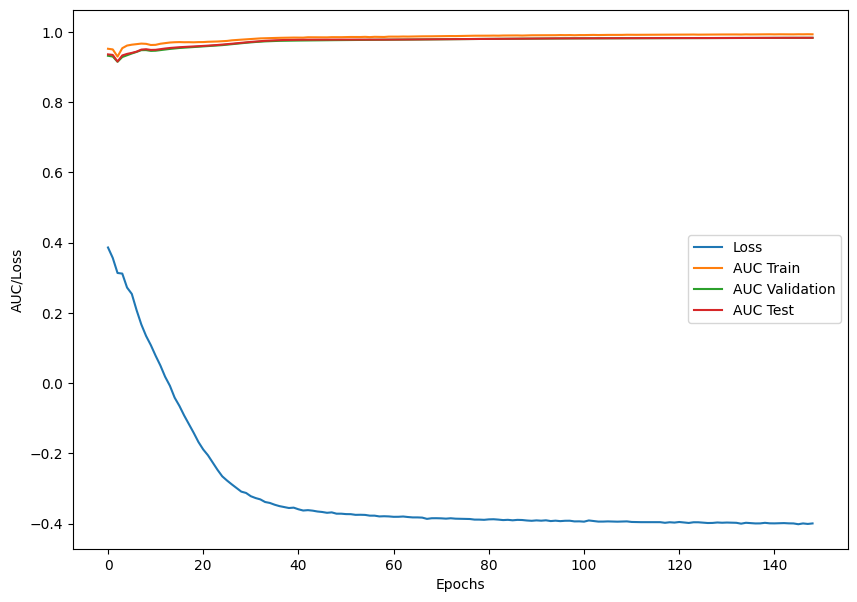

In [37]:
plt.figure(figsize= (10,7))
plt.plot(np.log10(performance[0]), label = 'Loss')
plt.plot(performance[1], label = 'AUC Train')
plt.plot(performance[2], label = 'AUC Validation')
plt.plot(performance[3], label = 'AUC Test')
plt.legend()
plt.ylabel('AUC/Loss')
plt.xlabel('Epochs')
plt.show()

Plot ROC curve using test set
- High TPR and lower FPR indicates that the proportion of correctly classified samples (true positives) is greater than the proportion of incorrectly classified samples (false positives)

0.9836136776859505


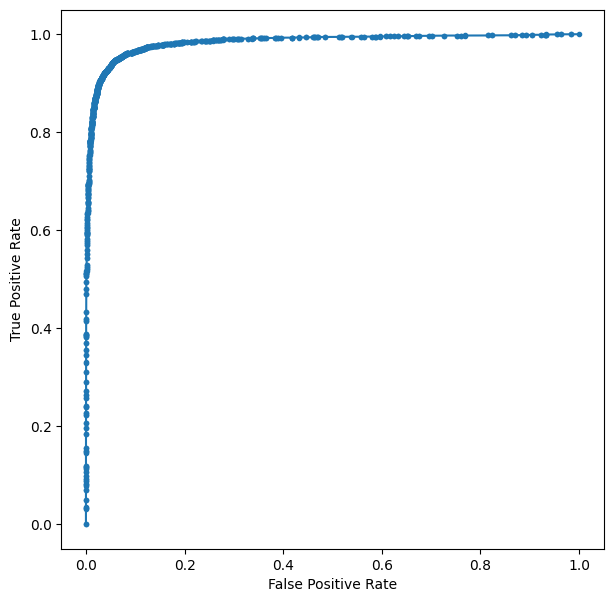

In [38]:
for batch in dataloaders['test']:
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    batch.to(args["device"])
    pred, x = best_model(feat, edge_index, edge_label_index, training = False)
    pred = torch.sigmoid(pred)
    score = roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    print(score)
    
fpr, tpr, thresholds = roc_curve(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')   # 1 - specificity
plt.ylabel('True Positive Rate')    # sensitivity
plt.show()

Calculate F1-score using test set

Elements of the F1-score:
- Precision represents the proportion of correctly classifying samples as positive (high precision: classifying a sample as positive has a high probability to be correct)
- Recall represents the proportion of finding all positives (high recall: all positive samples have been classified as being positive)

Maximizing both elements in order to yield a model that identifies all positive samples and only identifies these samples as positives.

For the F1-score, the average of precision and recall is calculated, using the harmonic mean method (equal importance):
- High F1-score indicates that precision and recall are both high
- Medium F1-score indicates that one of the elements is high and the other low
- Low F1-score indicates that precision and recall are both low

In [39]:
def test_f1(model, dataloader, args, threshold):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score += f1_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy(), score

true_label, pred_label, best_test_f1 = test_f1(best_model, dataloaders['test'], args, 0.75)
print('F1-Score in the test set:', best_test_f1)
print(classification_report(true_label, pred_label))

F1-Score in the test set: 0.9419016514099084
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11000
           1       0.95      0.93      0.94     11000

    accuracy                           0.94     22000
   macro avg       0.94      0.94      0.94     22000
weighted avg       0.94      0.94      0.94     22000



In [40]:
def test_cm(model, dataloader, args, threshold):
    model.eval()
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score = confusion_matrix(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    return score

table = test_cm(best_model, dataloaders['train'], args, 0.8)
print(table)

[[85410  2580]
 [ 2814 85176]]


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


# Hyperparameter Optimization of Node Embedding and GNN Training

The routine including node embedding and GNN training that needs to be optimized is contained in the function below.

In [41]:
def optim(args):
    # Node embedding using Edge2Vec
    trans_matrix = transitions.initialize_edge_type_matrix(args['type_size'])
    
    G1 = nx.from_pandas_edgelist(args['df'], 'index_head', 'index_tail', 'type', create_using=nx.DiGraph(), edge_key= (('type', int),('id',int)))
    G1 = G1.to_undirected()
    for edge in G1.edges():
        G1[edge[0]][edge[1]]['weight'] = 1.0
    
    for i in range(args['epoch_e2v']):
        walks = transitions.simulate_walks_1(G1, args['num_walks'], args['walk_length'], trans_matrix, True, args['p'], args['q'])
        trans_matrix = transitions.update_trans_matrix(walks,args['type_size'], 3)
    
    walks = edge2vec.simulate_walks_2(G1, args['num_walks'], args['walk_length'], trans_matrix, args['p'], args['q'])
    w2v_model = edge2vec.Word2Vec(walks, vector_size=args['dimensions_e2v'], window=args['walk_length']-1, min_count=0, sg=1, workers=8, epochs=args['epoch_e2v'])

    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(w2v_model.wv.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(w2v_model.wv[key])})
    e2v_embedding = e2v_embedding.sort_values('Node')
    
    # Build graph with nodes and their embedding as node feature
    G2 = nx.Graph()
    for ind, node in e2v_embedding.iterrows(): 
        G2.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
    for ind, edge in args['df'].iterrows(): 
        G2.add_edge(int(edge['index_head']), int(edge['index_tail']))
        
    # Split graph dataset into train, test and validation sets
    dataset = GraphDataset(G2, task='link_pred', edge_train_mode="all")
    
    datasets = {}
    datasets['train'], datasets['val'], datasets['test']= dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])
    
    
    # Set up link prediction model
    input_dim = datasets['train'].num_node_features
    
    model = LinkPredModel(input_dim, args['hidden_dim'], args['output_dim'], args['layers'], args['aggr'], args['dropout'], args['device']).to(args['device'])
    optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)
    
    
    # Generate dataloaders
    dataloaders = {split: DataLoader(ds, collate_fn=Batch.collate([]), batch_size=1, shuffle=(split=='train')) for split, ds in datasets.items()}
    
    best_model, best_x, perform = train(model, dataloaders, optimizer, args, ho = False)
    
    best_train_roc = test(best_model, dataloaders['train'], args)
    best_val_roc = test(best_model, dataloaders['val'], args)
    best_test_roc = test(best_model, dataloaders['test'], args)
    
    print('AUC:', best_test_roc)
    log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
    print(log.format(best_train_roc, best_val_roc, best_test_roc))
    tune.report(accuracy=best_val_roc)

Select the different parameters that need to be tested during the optimization search.

In [42]:
"""
search_args = {
    'device': torch_device, 
    "hidden_dim" : tune.choice([64, 128, 256]),
    'output_dim': tune.choice([64, 128, 256]),
    "epochs" : tune.choice([100, 150, 200]),
    'type_size' : len(set(edge2vec_df['type'])),
    'epoch_e2v' : tune.choice([5, 10]),
    'num_walks' : tune.choice([2, 4, 6]),
    'walk_length' : tune.choice([3, 5, 7]),
    'p' : tune.choice([0.5, 0.75, 1]),
    'q' : tune.choice([0.5, 0.75, 1]),
    'dimensions_e2v' : tune.choice([32, 64, 128]),
    'df': edge2vec_df, 
    'lr': tune.loguniform(1e-4, 1e-1), 
    'aggr': tune.choice(['mean', 'sum']), 
    'dropout': tune.choice([0, 0.1, 0.2]), 
    'layers': tune.choice([2, 4, 6])
}

scheduler = ASHAScheduler(
        max_t=10,
        grace_period=1,
        reduction_factor=2)

result = tune.run(
        tune.with_parameters(optim),
        resources_per_trial = {"cpu": 1}, #change this value according to the gpu units you would like to use
        config = search_args,
        metric = "val_auc",
        mode = "max",
        num_samples = 30, #select the maximum number of models you would like to test
        scheduler = scheduler, 
        resume = False, 
        local_dir = "output"
    )
"""

'\nsearch_args = {\n    \'device\': torch_device, \n    "hidden_dim" : tune.choice([64, 128, 256]),\n    \'output_dim\': tune.choice([64, 128, 256]),\n    "epochs" : tune.choice([100, 150, 200]),\n    \'type_size\' : len(set(edge2vec_df[\'type\'])),\n    \'epoch_e2v\' : tune.choice([5, 10]),\n    \'num_walks\' : tune.choice([2, 4, 6]),\n    \'walk_length\' : tune.choice([3, 5, 7]),\n    \'p\' : tune.choice([0.5, 0.75, 1]),\n    \'q\' : tune.choice([0.5, 0.75, 1]),\n    \'dimensions_e2v\' : tune.choice([32, 64, 128]),\n    \'df\': edge2vec_df, \n    \'lr\': tune.loguniform(1e-4, 1e-1), \n    \'aggr\': tune.choice([\'mean\', \'sum\']), \n    \'dropout\': tune.choice([0, 0.1, 0.2]), \n    \'layers\': tune.choice([2, 4, 6])\n}\n\nscheduler = ASHAScheduler(\n        max_t=10,\n        grace_period=1,\n        reduction_factor=2)\n\nresult = tune.run(\n        tune.with_parameters(optim),\n        resources_per_trial = {"cpu": 1}, #change this value according to the gpu units you would like 

In [43]:
"""
best_trial = result.get_best_trial("val_auc")
print("Best trial config: {}".format(best_trial.config))
"""

'\nbest_trial = result.get_best_trial("val_auc")\nprint("Best trial config: {}".format(best_trial.config))\n'

# GNN Predictions

Load the Edge2Vec embedding

In [44]:
node_feat = KeyedVectors.load('output/w2v.dvectors', mmap='r')

e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(node_feat.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')
e2v_embedding

,Node,Embedding
0,0,"[0.13517001, -0.25358334, 0.07978077, 0.045121..."
1,1,"[0.16805942, -0.8350107, 0.19610697, 0.1981789..."
2,2,"[0.2186089, 0.50546986, 0.6193271, 0.0123952, ..."
3,3,"[0.29987955, -0.30054563, 0.15258668, 0.367052..."
4,4,"[0.1618276, -0.36085665, 0.295463, 0.17283706,..."
...,...,...
10232,10232,"[0.3500288, -1.1846579, 0.15232153, 0.05306821..."
10233,10233,"[0.17927206, -0.17169905, -0.12125319, 0.18529..."
10234,10234,"[0.24352823, -0.24893956, 0.22431412, 0.153569..."
10235,10235,"[0.3218023, -0.7156479, 0.30151767, -0.3144425..."


Initialize a graph with nodes and their embedding features.

In [45]:
G = nx.Graph()
for ind, node in e2v_embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edge2vec_df.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']))
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.1352, -0.2536,  0.0798,  0.0451,  0.0747, -0.2546, -0.0705, -0.0646,
        -0.2445, -0.0202,  0.0493, -0.1636, -0.0623, -0.0508,  0.0288,  0.2002,
        -0.1173, -0.0943, -0.0744,  0.1843,  0.2936,  0.1871,  0.0121, -0.1656,
        -0.0181,  0.1075, -0.2460, -0.0466,  0.0871,  0.0957,  0.0087,  0.0946,
         0.0594, -0.0770, -0.0258,  0.0603, -0.0336, -0.0642,  0.0645,  0.0790,
        -0.0484, -0.0365, -0.0421,  0.0775,  0.1667, -0.0309,  0.0096, -0.1305,
        -0.0259,  0.1215,  0.0949,  0.0348,  0.1015,  0.1412,  0.0737,  0.0777,
         0.0288, -0.0531, -0.1087,  0.0693, -0.1133, -0.0443, -0.0622, -0.0670])})
(0, 5535, {})
Number of edges is 54994
Number of nodes is 10237


In [46]:
DeepG = Graph(G)

Load arguments and parameters of trained GNN model.

In [47]:
with open('output/best_model_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(e2v_embedding['Embedding'][0]), loaded_args['hidden_dim'], loaded_args['output_dim'], loaded_args['layers'], loaded_args['aggr'], loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load('output/best_model.pth'))

<All keys matched successfully>

Get output of best model given the graph

In [48]:
_, best_x = best_model(DeepG.node_feature, DeepG.edge_index, DeepG.edge_label_index, training = False)
print(best_x.shape)

torch.Size([10237, 64])


Define the score function

In [49]:
def score(x, id1, id2): 
    n1 = x[id1]
    n2 = x[id2]
    score = torch.Tensor([torch.sum(n1 * n2, dim=-1)])
    p = torch.sigmoid(score).cpu().detach().numpy()
    return p

def candidates(nodes, id, x): 
  ind = nodes[nodes['id'] == id].index.values.astype(int)[0]
  predictions = nodes.copy()
  scores = []
  for i in range(len(x)):  
    s = score(x, i, ind)
    scores.append(s)
  predictions['Score'] = scores
  return predictions

Calculate the predictions of an edge existing or not between given node ID and each node in the graph contained by semantic group DRUG. Show the top 20 highest probability that an edge exists between a pair of nodes.

In [50]:
predictions = candidates(nodes, 'HP:0001265', best_x)
predictions[predictions['semantic'] == 'drug'].sort_values(by = ['Score'], ascending = False).head(20)

,id,semantic,label,semantic_id,Score
2278,1423,drug,imatinib,4,[0.95922834]
10137,522,drug,carvedilol,4,[0.95486367]
7572,1576,drug,levosimendan,4,[0.95100147]
5414,629,drug,cianidanol,4,[0.9350761]
4345,3514,drug,quercetin,4,[0.93371826]
3135,1795,drug,mezlocillin,4,[0.9330587]
3415,4225,drug,axitinib,4,[0.9296969]
5354,4716,drug,ponatinib,4,[0.92575926]
6018,186,drug,amodiaquine,4,[0.91975147]
10039,2459,drug,sorafenib,4,[0.9173793]


Use the node semantics dictionary

In [51]:
node_semantic_dict

{0: 'biological artifact',
 1: 'biological process',
 2: 'cellular component',
 3: 'disease',
 4: 'drug',
 5: 'gene',
 6: 'genotype',
 7: 'molecular function',
 8: 'phenotype',
 9: 'taxon',
 10: 'variant'}

Get all phenotypes and diseases relevant to the disease.

In [52]:
disease_ID = 'MONDO:0010679'
relation_index = list(relation_labels).index('associated with phenotype')

symptoms = edge2vec_df[(edge2vec_df['head'] == 'MONDO:0010679') & (edge2vec_df['type'] == relation_index)]

print(f'A total of {symptoms.shape[0]} symptoms found that are associated with {disease_ID}')
symptoms.head(symptoms.shape[0])

A total of 27 symptoms found that are associated with MONDO:0010679


,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
5734,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0001265,Hyporeflexia,8,489,8
5831,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0001371,Flexion contracture,8,1896,8
22263,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0001644,Dilated cardiomyopathy,8,2621,8
22928,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0003202,Skeletal muscle atrophy,8,1574,8
24828,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0001256,"Intellectual disability, mild",8,2191,8
29977,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0003236,Elevated serum creatine kinase,8,8294,8
34690,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0011675,Arrhythmia,8,9501,8
36112,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0000750,Delayed speech and language development,8,1393,8
39506,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0003707,Calf muscle pseudohypertrophy,8,7286,8
43931,MONDO:0010679,Duchenne muscular dystrophy,3,4672,associated with phenotype,HP:0002791,Hypoventilation,8,4540,8


Check alignment between dataframes containing the associations and the nodes

In [53]:
# Above dataframe indicates that index 4672 represents MONDO:0010679
nodes.loc[[4672]]

,id,semantic,label,semantic_id
4672,MONDO:0010679,disease,Duchenne muscular dystrophy,3


## Component Analysis

In [54]:
X_data = best_x.detach().cpu().numpy()
z = StandardScaler().fit_transform(X_data)

### PCA

In [55]:
pca = PCA(n_components=32)
princ_comp = pca.fit_transform(z)
princ_df = pd.DataFrame(data=princ_comp[:, [0,1]], columns=['principal component 1', 'principal component 2'])
princ_df

,principal component 1,principal component 2
0,0.446142,0.534077
1,2.293720,4.447126
2,-6.838203,0.169032
3,-0.561996,0.125219
4,0.233409,0.368575
...,...,...
10232,3.966065,5.278153
10233,1.533181,-2.547646
10234,2.304482,-0.908369
10235,-0.306509,2.251463


Based on plot below, choose the number of components for PCA analysis yielding an amount of variance close to 1.0.

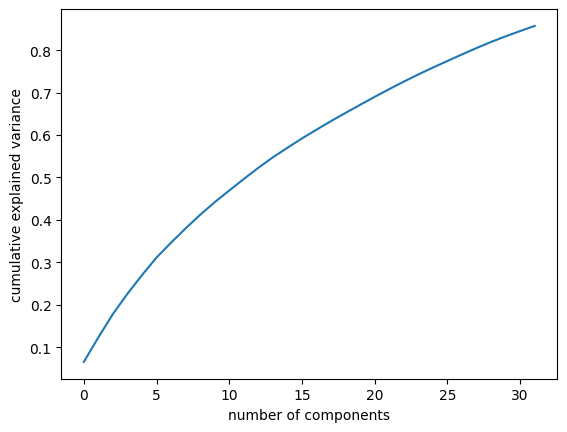

In [56]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [57]:
pca_df = pd.concat([princ_df, nodes[['semantic']]], axis=1)
pca_df

,principal component 1,principal component 2,semantic
0,0.446142,0.534077,phenotype
1,2.293720,4.447126,phenotype
2,-6.838203,0.169032,gene
3,-0.561996,0.125219,gene
4,0.233409,0.368575,phenotype
...,...,...,...
10232,3.966065,5.278153,genotype
10233,1.533181,-2.547646,phenotype
10234,2.304482,-0.908369,variant
10235,-0.306509,2.251463,phenotype


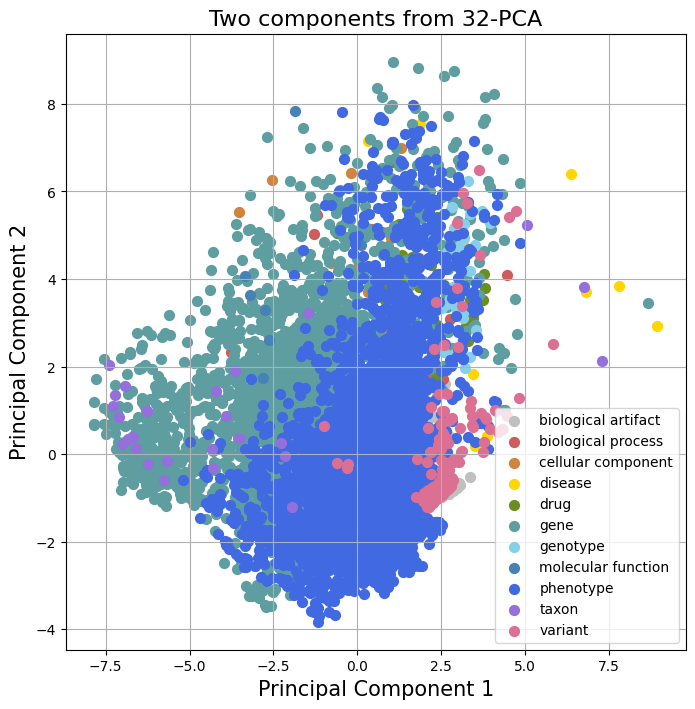

In [58]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two components from 32-PCA', fontsize = 16)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = pca_df['semantic'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()

### t-SNE

In [59]:
X_tsne = TSNE(learning_rate=100, perplexity=40).fit_transform(X_data)

In [60]:
comp_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
comp_tsne

,t-SNE 1,t-SNE 2
0,-15.840627,-14.440085
1,34.953640,43.717522
2,-59.741489,4.701775
3,40.269527,11.425534
4,25.444637,29.404465
...,...,...
10232,-9.552385,39.669540
10233,-18.560886,-69.567749
10234,55.157284,-11.451155
10235,-6.824839,31.584152


In [61]:
tsne_df = pd.concat([comp_tsne, nodes[['semantic']]], axis=1)
tsne_df

,t-SNE 1,t-SNE 2,semantic
0,-15.840627,-14.440085,phenotype
1,34.953640,43.717522,phenotype
2,-59.741489,4.701775,gene
3,40.269527,11.425534,gene
4,25.444637,29.404465,phenotype
...,...,...,...
10232,-9.552385,39.669540,genotype
10233,-18.560886,-69.567749,phenotype
10234,55.157284,-11.451155,variant
10235,-6.824839,31.584152,phenotype


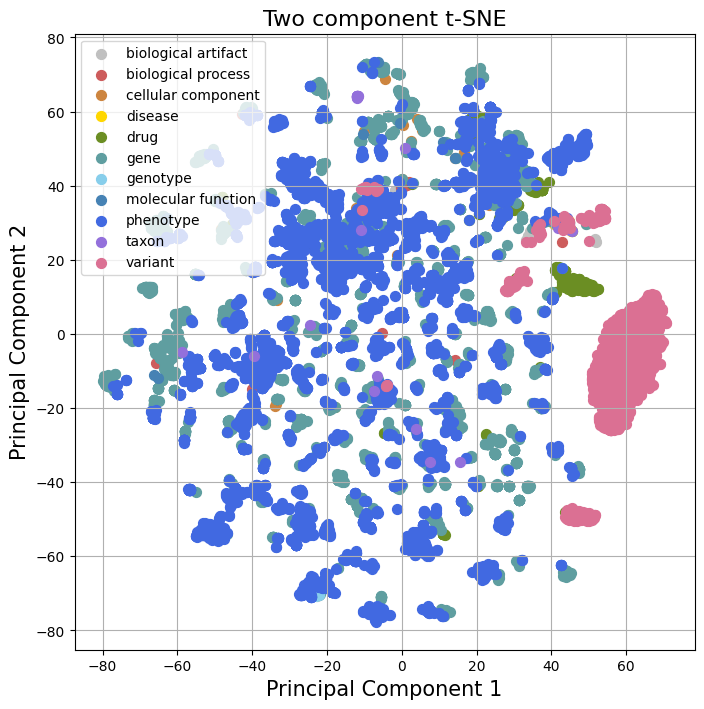

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component t-SNE', fontsize = 16)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = tsne_df['semantic'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'], tsne_df.loc[indicesToKeep, 't-SNE 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()

## GNNExplainer

In [79]:
"""
    Copy of source code in TORCH_GEOMETRIC.NN.MODELS.GNN_EXPLAINER from torch_geometric version 2.0.4 
    with adaptations https://github.com/PPerdomoQ/rare-disease-explainer/blob/main/3_Predictions_and_explanations.ipynb
"""

from math import sqrt
from typing import Optional
import copy

import torch
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
from inspect import signature

from torch_geometric.nn.models.explainer import (
    Explainer,
    clear_masks,
    set_masks,
)

EPS = 1e-15


class GNNExplainer(Explainer):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model
            returns the logarithm of probabilities), :obj:`"prob"` (the
            model returns probabilities), :obj:`"raw"` (the model returns raw
            scores) and :obj:`"regression"` (the model returns scalars).
            (default: :obj:`"log_prob"`)
        feat_mask_type (str, optional): Denotes the type of feature mask
            that will be learned. Valid inputs are :obj:`"feature"` (a single
            feature-level mask for all nodes), :obj:`"individual_feature"`
            (individual feature-level masks for each node), and :obj:`"scalar"`
            (scalar mask for each each node). (default: :obj:`"feature"`)
        allow_edge_mask (boolean, optional): If set to :obj:`False`, the edge
            mask will not be optimized. (default: :obj:`True`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
        **kwargs (optional): Additional hyper-parameters to override default
            settings in :attr:`~torch_geometric.nn.models.GNNExplainer.coeffs`.
    """

    coeffs = {
        'edge_size': 0.00005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01, num_hops: Optional[int] = None, 
                 return_type: str = 'log_prob', feat_mask_type: str = 'feature', allow_edge_mask: bool = True,
                 log: bool = True, **kwargs):
        
        super().__init__(model, lr, epochs, num_hops, return_type, log)
        
        assert feat_mask_type in ['feature', 'individual_feature', 'scalar']
        
        self.allow_edge_mask = allow_edge_mask
        self.feat_mask_type = feat_mask_type
        self.coeffs.update(kwargs)

    def _initialize_masks(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        std = 0.1

        if self.feat_mask_type == 'individual_feature':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, F) * std)
        elif self.feat_mask_type == 'scalar':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, 1) * std)
        else:
            self.node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))

        if self.allow_edge_mask:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

    def _clear_masks(self):
        clear_masks(self.model)
        self.node_feat_masks = None
        self.edge_mask = None

    def _loss(self, log_logits, prediction, node_idx: Optional[int] = None):
        if self.return_type == 'regression':
            if node_idx is not None and node_idx >= 0:
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and node_idx >= 0:
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_graph(self, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, batch=batch,
                                                 **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)
        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            loss = self.get_loss(out, prediction, None)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid().squeeze()
        if self.allow_edge_mask:
            edge_mask = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.ones(edge_index.size(1))

        self._clear_masks()
        return node_feat_mask, edge_mask


    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.subgraph(node_idx, -x, edge_index, **kwargs)
        print('Edge Index 1:', edge_index)
        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)
        print('Prediction:', prediction)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        print('Edge Index 2:', edge_index)
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            print('X:', x)
            print('H:', h)
            print('Mask:', self.node_feat_mask.sigmoid())
            print('Edge Index 3:', edge_index)
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            print('Out:', out)
            print('Prediction:', prediction)
            loss = self.get_loss(out, prediction, mapping)
            print('Loss:', loss)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)
        print('Out:', out)
        print('Mapping:', mapping )
        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            print('Hard Edges:', hard_edge_mask)
            print('Len Hard Edges:', len(hard_edge_mask))
            print('Edges:', edge_mask)
            print('Len Edges:', len(edge_mask))      
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

    def __repr__(self):
        return f'{self.__class__.__name__}()'
    
    def explain_link(self, node_idx1, node_idx2, x, edge_index, **kwargs): 
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        _, emb = self.model(x, edge_index, edge_index)  # yielded node embeddings used to calculate edge existing or not


        # Only operate on a k-hop subgraph around `node_idx1`.
        x1, edge_index1, mapping1, hard_edge_mask1, subset1, kwargs1 = subgraph(node_idx=[node_idx1, node_idx2], 
                                                                                x=x, edge_index=edge_index, 
                                                                                flow='source_to_target', num_hops = self.num_hops, **kwargs)

        # Only operate on a k-hop subgraph around `node_idx2`.
        # x2, edge_index2, mapping2, hard_edge_mask2, subset2, kwargs2 = self.subgraph(node_idx2, x, edge_index, **kwargs)

        # initial embedding
        node_embedding_1 = emb[node_idx1]
        node_embedding_2 = emb[node_idx2]

        # Get the initial prediction.       
        prediction = torch.Tensor([torch.sum(node_embedding_1 * node_embedding_2, dim=-1)]).requires_grad_()

        self._initialize_masks(x1, edge_index1)
        self.to(x1.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index1,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
            
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx1}')
        
        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            criterion = torch.nn.MSELoss(reduction='sum')
            h = x1 
            # # print('X:', x1)
            # # print('H:', h)
            # # print('Mask:', self.node_feat_mask.sigmoid())
            # G1 = nx.Graph()
            # for ind, node in enumerate(h): 
            #   G1.add_node(ind, node_feature=node)
            # for i in range(edge_index1.size(1)): 
            #   G1.add_edge(edge_index1[0][i].item(), edge_index1[1][i].item())
            
            # # print("Number of edges is {}".format(G1.number_of_edges()))
            # # print("Number of nodes is {}".format(G1.number_of_nodes()))
            # dataset1 = GraphDataset(
            #   G1,
            #   task='link_pred',
            #   edge_train_mode="all")
            
            # dataloader1 = DataLoader(
            #     dataset1, collate_fn=Batch.collate([]),
            #     batch_size=1, shuffle=False)
        
            # for i, batch in enumerate(dataloader1):
            _, emb1 = self.model(h, edge_index1, edge_index1)
            
            # for module in self.model.modules():  
            #   if isinstance(module, MessagePassing):
            #     print(module._edge_mask)
              # module._loop_mask = loop_mask
              # module._apply_sigmoid = apply_sigmoid

            out = torch.tensor([torch.sum(emb1[mapping1[1]]* emb1[mapping1[0]], dim=-1)]).requires_grad_()
            # print('Out:', out)
            # print('Prediction:', prediction)
            loss = criterion(out, prediction)
            #loss = self.get_loss(out, prediction, mapping1)
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()
            # m = self.node_feat_mask.sigmoid()
            # node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
            # loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
            # ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            # loss = loss + self.coeffs['node_feat_ent'] * ent.mean()
            # print('Loss:', loss)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x1.new_zeros(num_nodes, x1.size(-1))
            new_mask[subset1] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x1.new_zeros(num_nodes, 1)
            new_mask[subset1] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()
        # print('Non Zero:', torch.count_nonzero(node_feat_mask))

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            # print('Hard Edges:', hard_edge_mask1)
            # print('Len Hard Edges:', len(hard_edge_mask1))
            # print('Non Zero:', torch.count_nonzero(hard_edge_mask1))
            # print('Edges:', edge_mask)
            # print('Len Edges:', len(edge_mask))            
            edge_mask[hard_edge_mask1] = self.edge_mask.detach().sigmoid()
            #print('Edge Mask:', self.edge_mask.detach().sigmoid())
            # print('Non Zero:', torch.count_nonzero(edge_mask))
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask1] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask
    
def maybe_num_nodes(index, num_nodes=None):
    return index.max().item() + 1 if num_nodes is None else num_nodes

def k_hop_subgraph(node_idx, num_hops, edge_index, relabel_nodes=False,
                   num_nodes=None, flow='source_to_target'):
    r"""Computes the :math:`k`-hop subgraph of :obj:`edge_index` around node
    :attr:`node_idx`.
    It returns (1) the nodes involved in the subgraph, (2) the filtered
    :obj:`edge_index` connectivity, (3) the mapping from node indices in
    :obj:`node_idx` to their new location, and (4) the edge mask indicating
    which edges were preserved.

    Args:
        node_idx (int, list, tuple or :obj:`torch.Tensor`): The central
            node(s).
        num_hops: (int): The number of hops :math:`k`.
        edge_index (LongTensor): The edge indices.
        relabel_nodes (bool, optional): If set to :obj:`True`, the resulting
            :obj:`edge_index` will be relabeled to hold consecutive indices
            starting from zero. (default: :obj:`False`)
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        flow (string, optional): The flow direction of :math:`k`-hop
            aggregation (:obj:`"source_to_target"` or
            :obj:`"target_to_source"`). (default: :obj:`"source_to_target"`)

    :rtype: (:class:`LongTensor`, :class:`LongTensor`, :class:`LongTensor`,
             :class:`BoolTensor`)
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    assert flow in ['source_to_target', 'target_to_source']
    if flow == 'target_to_source':
        row, col = edge_index
    else:
        col, row = edge_index

    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    if isinstance(node_idx, (int, list, tuple)):
        node_idx = torch.tensor([node_idx], device=row.device).flatten()
    else:
        node_idx = node_idx.to(row.device)

    subsets = [node_idx]

    for _ in range(num_hops):
        node_mask.fill_(False)
        
        node_mask_index = subsets[-1].long()
        node_mask[node_mask_index] = True
        
        torch.index_select(node_mask, 0, row, out=edge_mask)
        subsets.append(col[edge_mask])

    subset, inv = torch.cat(subsets).unique(return_inverse=True)
    inv = inv[:node_idx.numel()]

    node_mask.fill_(False)
    node_mask[subset] = True
    edge_mask = node_mask[row] & node_mask[col]

    edge_index = edge_index[:, edge_mask]

    if relabel_nodes:
        node_idx = row.new_full((num_nodes, ), -1)
        node_idx[subset] = torch.arange(subset.size(0), device=row.device)
        edge_index = node_idx[edge_index]

    return subset, edge_index, inv, edge_mask

def subgraph(node_idx, x, edge_index, num_hops, **kwargs):
    r"""Returns the subgraph of the given node.

    Args:
        node_idx (int): The node to explain.
        x (Tensor): The node feature matrix.
        edge_index (LongTensor): The edge indices.
        **kwargs (optional): Additional arguments passed to the GNN module.
    :rtype: (Tensor, Tensor, LongTensor, LongTensor, LongTensor, dict)
    """
    num_nodes, num_edges = x.size(0), edge_index.size(0)
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, num_hops, edge_index, relabel_nodes=True, num_nodes=num_nodes, flow = 'source_to_target')

    x = x[subset]
    kwargs_new = {}
    for key, value in kwargs.items():
        if torch.is_tensor(value) and value.size(0) == num_nodes:
            kwargs_new[key] = value[subset]
        elif torch.is_tensor(value) and value.size(0) == num_edges:
            kwargs_new[key] = value[edge_mask]
        kwargs_new[key] = value  # TODO: this is not in PGExplainer
    return x, edge_index, mapping, edge_mask, subset, kwargs_new
    
def visualize_subgraph(node_idx, edge_index_full,
                        edge_mask, nodes, y = None,
                        threshold = None,
                        edge_y = None,
                        node_alpha = None, seed= 10,
                       flow = 'source_to_target', 
                       num_hops = 1,node_label = 'preflabel',
                       edge_labels = None,
                       show_inactive = False,
                       remove_unconnected = False,
                       
                        **kwargs):
    r"""Visualizes the subgraph given an edge mask :attr:`edge_mask`.

    Args:
        node_idx (int): The node id to explain.
            Set to :obj:`None` to explain a graph.
        edge_index (LongTensor): The edge indices.
        edge_mask (Tensor): The edge mask.
        y (Tensor, optional): The ground-truth node-prediction labels used
            as node colorings. All nodes will have the same color
            if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
        threshold (float, optional): Sets a threshold for visualizing
            important edges. If set to :obj:`None`, will visualize all
            edges with transparancy indicating the importance of edges.
            (default: :obj:`None`)
        edge_y (Tensor, optional): The edge labels used as edge colorings.
        node_alpha (Tensor, optional): Tensor of floats (0 - 1) indicating
            transparency of each node.
        seed (int, optional): Random seed of the :obj:`networkx` node
            placement algorithm. (default: :obj:`10`)
        **kwargs (optional): Additional arguments passed to
            :func:`nx.draw`.

    :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    assert edge_mask.size(0) == edge_index_full.size(1)

    if node_idx is None or node_idx[0] < 0:
        hard_edge_mask = torch.BoolTensor([True] * edge_index_full.size(1),
                                          device=edge_mask.device)
        subset = torch.arange(edge_index_full.max().item() + 1,
                              device=edge_index_full.device)
        y = None

    else:
        # Only operate on a k-hop subgraph around `node_idx`.
        subset, edge_index, mapping_sub, hard_edge_mask = k_hop_subgraph(
            node_idx, num_hops, edge_index_full, relabel_nodes=True,
            num_nodes=None, flow=flow)
        

    edge_mask = edge_mask[hard_edge_mask]
    selected = (hard_edge_mask == True).nonzero(as_tuple=True)

    if threshold is not None:
        edge_mask = (edge_mask >= threshold).to(torch.float)

    if y is None:
        y = torch.zeros(edge_index.max().item() + 1,
                        device=edge_index.device)
    else:
        #print(y[subset])
        y = y[subset].to(torch.float) / y.max().item()
        

    if edge_y is None:
        edge_color = ['black'] * edge_index.size(1)
    else:
        colors = list(plt.rcParams['axes.prop_cycle'])
        edge_color = [
            colors[i % len(colors)]['color']
            for i in edge_y[hard_edge_mask]
        ]


    data = Data(edge_index=edge_index, att=edge_mask,
                edge_color=edge_color, y=y, num_nodes=y.size(0)).to('cpu')
    #print(data)
    G = to_networkx(data, node_attrs=['y'],
                    edge_attrs=['att', 'edge_color'])

    #print(G.number_of_nodes())
    #print(node_label)
    
    #print(mapping)

    #print(len(torch.stack((edge_index[0], edge_index[1])).unique()))
    #print(G.number_of_edges())
    G2 = copy.deepcopy(G)
    if num_hops >= 1 and not show_inactive: 
      for indx, edge in enumerate(G.edges): 
        if edge_mask[indx] <  threshold:
          G2.remove_edge(edge[0], edge[1])
      removed_nodes = list(nx.isolates(G2))
      G2.remove_nodes_from(removed_nodes)

    
    if remove_unconnected:
        G2 = G2.to_undirected()
        for component in list(nx.connected_components(G2)):
            if mapping_sub[0].item() in component or mapping_sub[1].item() in component:
                continue
            else:
                for node in component:
                    G2.remove_node(node)
                    

    active = torch.tensor(list(G2.nodes()))

    mapping = {k: str(nodes.iloc[i][node_label]) + ' ' + str(i) for k, i in enumerate(subset.tolist())}
    mapping2 = {str(nodes.iloc[i][node_label]) + ' ' + str(i): i for k, i in enumerate(subset.tolist())}
    G2 = nx.relabel_nodes(G2, mapping)

    node_args = set(signature(nx.draw_networkx_nodes).parameters.keys())
    node_kwargs = {k: v for k, v in kwargs.items() if k in node_args}
    node_kwargs['node_size'] = kwargs.get('node_size') or 800
    node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

    label_args = set(signature(nx.draw_networkx_labels).parameters.keys())
    label_kwargs = {k: v for k, v in kwargs.items() if k in label_args}
    label_kwargs['font_size'] = kwargs.get('font_size') or 10

    pos = nx.spring_layout(G2, seed=seed)
    ax = plt.gca()
    for source, target, data in G2.edges(data=True):
        ax.annotate(
            '', xy=pos[target], xycoords='data', xytext=pos[source],
            textcoords='data', arrowprops=dict(
                arrowstyle="->",
                alpha=max(data['att'], 0.1),
                color=data['edge_color'],
                shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                connectionstyle="arc3,rad=0.1",
            ))

    if node_alpha is None:
        #print(active)
        nx.draw_networkx_nodes(G2, pos, node_color=y[active].tolist(),
                                **node_kwargs)
    else:
        node_alpha_subset = node_alpha[subset]
        assert ((node_alpha_subset >= 0) & (node_alpha_subset <= 1)).all()
        nx.draw_networkx_nodes(G2, pos, alpha=node_alpha_subset.tolist(),
                                node_color=y.tolist(), **node_kwargs)

    nx.draw_networkx_labels(G2, pos, **label_kwargs)

    if edge_labels is not None: 

      edge_labels_sub = {}
      for (n1,n2) in G2.edges(): 
        #print(n1)
        edge_labels_sub[(n1, n2)] = edge_labels[(mapping2[n1], mapping2[n2])]
      
      nx.draw_networkx_edge_labels(
      G2, pos,
      edge_labels=edge_labels_sub,
      font_color='red', 
      font_size = 10
  )

    return ax, G2

Explanations will be generated

In [64]:
e2v_embedding

,Node,Embedding
0,0,"[0.13517001, -0.25358334, 0.07978077, 0.045121..."
1,1,"[0.16805942, -0.8350107, 0.19610697, 0.1981789..."
2,2,"[0.2186089, 0.50546986, 0.6193271, 0.0123952, ..."
3,3,"[0.29987955, -0.30054563, 0.15258668, 0.367052..."
4,4,"[0.1618276, -0.36085665, 0.295463, 0.17283706,..."
...,...,...
10232,10232,"[0.3500288, -1.1846579, 0.15232153, 0.05306821..."
10233,10233,"[0.17927206, -0.17169905, -0.12125319, 0.18529..."
10234,10234,"[0.24352823, -0.24893956, 0.22431412, 0.153569..."
10235,10235,"[0.3218023, -0.7156479, 0.30151767, -0.3144425..."


In [65]:
edge2vec_df

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,FlyBase:FBgn0011676,Nos,5,9594,in orthology relationship with,ENSEMBL:ENSCAFG00000009820,ENSEMBL:ENSCAFG00000009820,5,7362,0
1,HGNC:12012,TPM3,5,1813,interacts with,HGNC:11946,TNNI2,5,7360,1
2,HGNC:15516,XYLT1,5,3228,causes condition,HP:0002650,Scoliosis,8,2102,2
3,WormBase:WBGene00000065,act-3,5,3272,in orthology relationship with,ENSEMBL:ENSOANG00000007850,ENSEMBL:ENSOANG00000007850,5,2284,0
4,HGNC:6485,LAMA5,5,4641,interacts with,HGNC:329,AGRN,5,2205,1
...,...,...,...,...,...,...,...,...,...,...
85949,dictyBase:DDB_G0276459,pakB,5,3746,in orthology relationship with,WormBase:WBGene00003911,pak-1,5,6906,0
85950,ZFIN:ZDB-GENE-030113-2,ttn.2,5,6355,causes condition,ZP:0106692,"Z disc myocardium disorganized, abnormal",8,6931,2
85951,ENSEMBL:ENSGALG00000015211,DTNA,5,828,in orthology relationship with,ENSEMBL:ENSECAG00000020912,ENSEMBL:ENSECAG00000020912,5,6757,0
85952,ENSEMBL:ENSECAG00000000207,ENSEMBL:ENSECAG00000000207,5,8915,in orthology relationship with,WormBase:WBGene00000064,act-2,5,5490,0


In [66]:
G = nx.Graph()

for ind, node in e2v_embedding.iterrows():
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edge2vec_df.iterrows(): 
  G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.1352, -0.2536,  0.0798,  0.0451,  0.0747, -0.2546, -0.0705, -0.0646,
        -0.2445, -0.0202,  0.0493, -0.1636, -0.0623, -0.0508,  0.0288,  0.2002,
        -0.1173, -0.0943, -0.0744,  0.1843,  0.2936,  0.1871,  0.0121, -0.1656,
        -0.0181,  0.1075, -0.2460, -0.0466,  0.0871,  0.0957,  0.0087,  0.0946,
         0.0594, -0.0770, -0.0258,  0.0603, -0.0336, -0.0642,  0.0645,  0.0790,
        -0.0484, -0.0365, -0.0421,  0.0775,  0.1667, -0.0309,  0.0096, -0.1305,
        -0.0259,  0.1215,  0.0949,  0.0348,  0.1015,  0.1412,  0.0737,  0.0777,
         0.0288, -0.0531, -0.1087,  0.0693, -0.1133, -0.0443, -0.0622, -0.0670])})
(0, 5535, {'edge_label': 'causes condition'})
Number of edges is 54994
Number of nodes is 10237


Obtain predictions for links between node HP:0003560 with any drug node.

In [67]:
predictions = candidates(nodes, 'HP:0003560', best_x)
predictions[predictions['semantic'] == 'drug'].sort_values(by = ['Score'], ascending = False).head(20)

,id,semantic,label,semantic_id,Score
10137,522,drug,carvedilol,4,[0.9437079]
7572,1576,drug,levosimendan,4,[0.94072086]
1881,231,drug,aprindine,4,[0.8937863]
3755,926,drug,disopyramide,4,[0.8792722]
2278,1423,drug,imatinib,4,[0.8492114]
5414,629,drug,cianidanol,4,[0.8442495]
6018,186,drug,amodiaquine,4,[0.831501]
4345,3514,drug,quercetin,4,[0.83051103]
2658,4285,drug,Florbetapir F-18,4,[0.81454134]
9585,2835,drug,nicotinic acid,4,[0.80421597]


Obtain the indices of the nodes of interest.

In [82]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

node_idx1 = get_node_idx('HP:0003560', nodes)
print('node1:')
print(nodes.loc[[node_idx1]])

node_idx2 = get_node_idx('522', nodes)
print('node2:')
print(nodes.loc[[node_idx2]])

node1:
             id   semantic               label  semantic_id
184  HP:0003560  phenotype  Muscular dystrophy            8
node2:
        id semantic       label  semantic_id
10137  522     drug  carvedilol            4


Obtain the embedding features per node.

In [83]:
x = torch.Tensor(e2v_embedding['Embedding'])
print(x.shape)

torch.Size([10237, 64])


Obtain the indices of the head and tail nodes per edge.

In [84]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)
print(edge_index.type())

torch.Size([2, 54994])
torch.LongTensor


In [97]:
explainer = GNNExplainer(best_model, epochs=700, num_hops=2, lr=0.01)

edge_list = []
trigger = False
early_stop = 0
size = 15   # change size of the explanation graph
iterations = 10 # number of times GNNExplainer is executed

while not trigger:
    node_feat_mask, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2, x=x, edge_index=edge_index, G=G)

    G2 = copy.deepcopy(G)
    
    if size is not None: 
        limit = edge_mask.sort(descending = True)[0][size]
    else: 
        limit = 0.5

    for indx, edge in enumerate(G.edges): 
        if edge_mask[indx] < limit:
            G2.remove_edge(edge[0], edge[1])

    trigger = nx.has_path(G2, node_idx1, node_idx2)
    early_stop += 1
    
    if early_stop == iterations and not trigger:
        print('No good explanation found after {} iterations'.format(early_stop))
        trigger = True
    elif trigger: 
        print('Explanation found!')

Explain node 184: 100%|██████████| 700/700 [00:01<00:00, 475.10it/s]


Explanation found!


In [98]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])

In [105]:
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))


Number of edges is 54994
Number of nodes is 10237
True


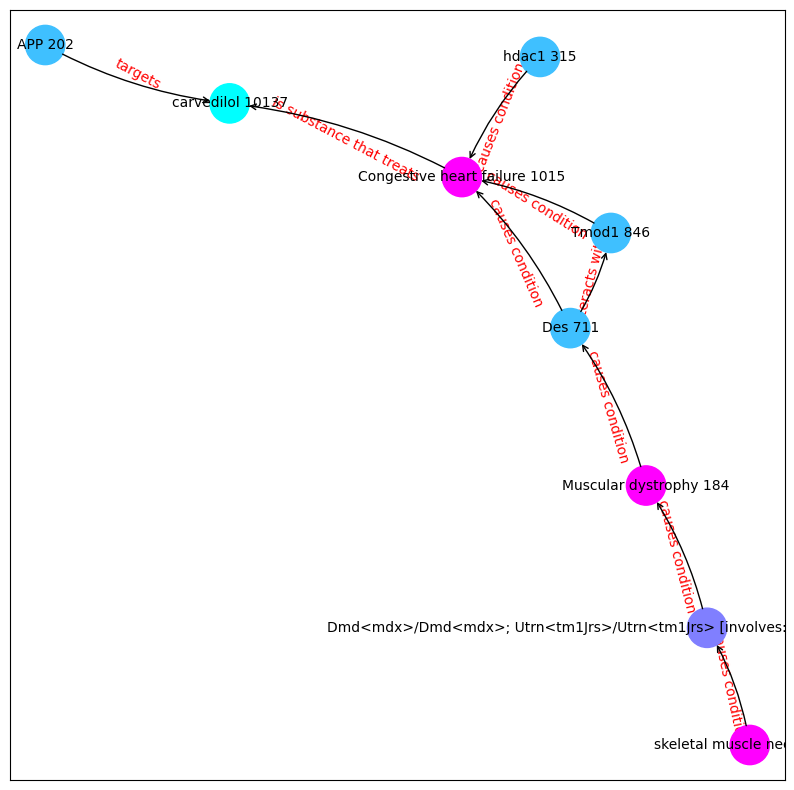

In [103]:
plt.figure(figsize=(10, 10))
ax, G_sub = visualize_subgraph([node_idx1, node_idx2], 
                               edge_index, edge_mask, nodes=nodes, y=torch.Tensor(nodes.semantic_id), 
                               seed = 667, num_hops = 2, threshold=limit, node_label = 'label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
